In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle

In [2]:
data_paths = {  'ntp'    : 'ntp_ddos_14_minutes.csv',
                'udp'    : 'udp_ddos_2_minutes.csv',
                'syn'    : 'syn_ddos_3_minutes.csv',
                'benign' : 'ntp_benign_10_minutes.csv'}

dataset_dict = {    'ntp' : None, 'udp' : None,
                    'syn' : None, 'benign' : None}

In [3]:
def upload_dataset_with_time(path:str):
    startingT = time.perf_counter()
    if 'pkl' in path:
        veriseti = pd.read_pickle(path)
    else:
        veriseti = pd.read_csv(path, low_memory=True)
    endingT = time.perf_counter()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

In [4]:
for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    if 'benign' in data_name:
        #manipulation
        data["Label"] = data["Label"].apply(lambda x: 0)
        
    dataset_dict[data_name] = data

Dataset is loaded in 0.012140699999999782 seconds
Dataset is loaded in 0.004270199999999669 seconds
Dataset is loaded in 0.00381829999999983 seconds
Dataset is loaded in 0.01000330000000016 seconds


## 1. Veriseti İşlemleri

CiC veriseti 2 farklı atak tipini içeriyor.<br> 
1- Reflection Attacks<br>
2- Exploitation Attacks<br><br>

Explotitation : Syn Flood , UDP Flood<br>
Reflection : NTP <br>
Ataklarını alarak işlemlere başladık. İlk olarak bu veriseti flow based kaydedilmiş.<br>
Matrix Profile ile incelemek için, data paketlerini bir time series'e dönüştürme işlemi gerçekleştirdim.<br>
Bunu yaparken, ilk olarak saniye cinsinden flowları grupladım.<br>

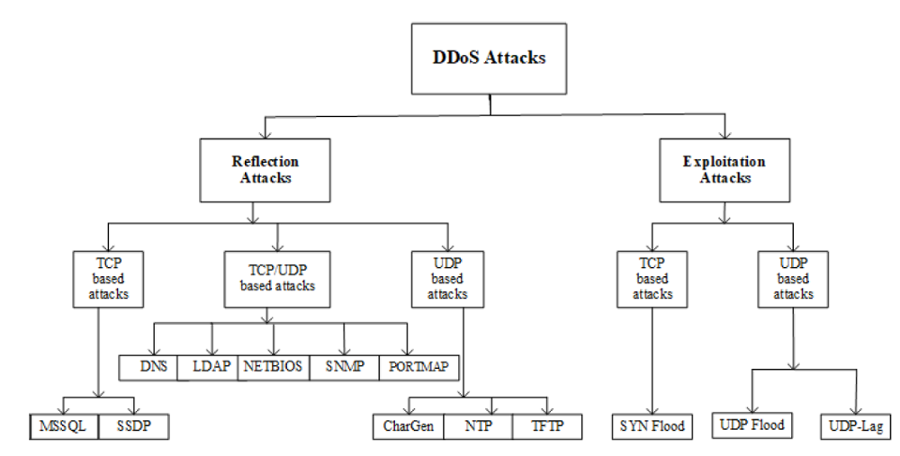

In [5]:
from IPython.display import Image
Image('gorseller/ddos_attacks.png',  width=700, height=450)

#### İşlenmeden önceki Syn Flood veriseti

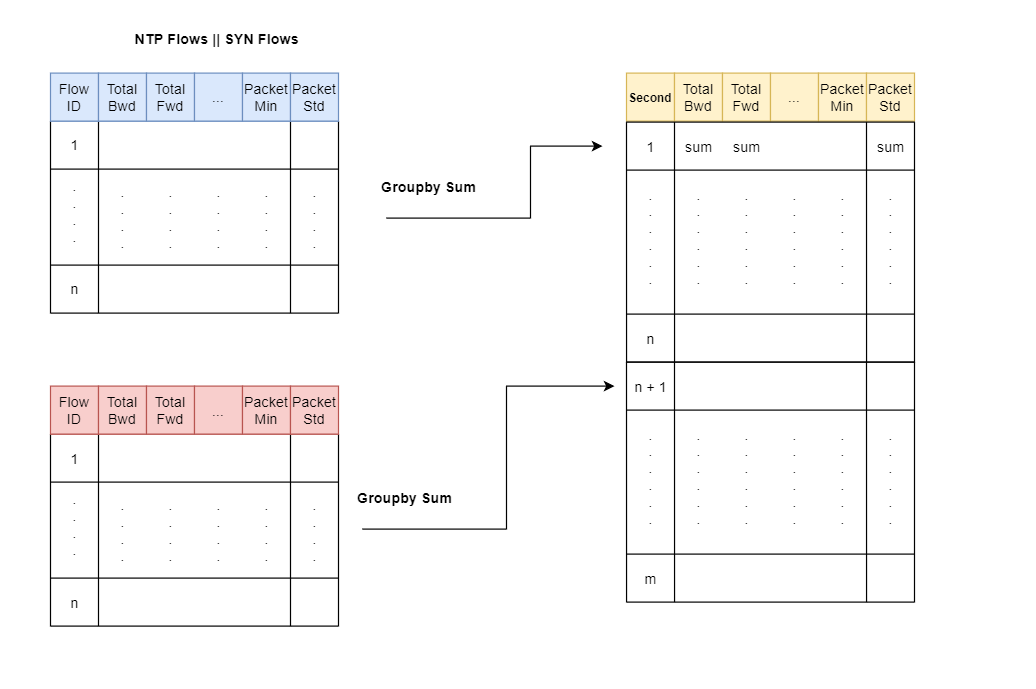

In [6]:
Image('gorseller/data_process_seconds.png', width=800, height=400)

In [7]:
temp_syn_all = pd.read_pickle("../verisetleri/syn.pkl")
print(f"row data sayisi: {temp_syn_all.shape[0]}\nFeature sayisi : {temp_syn_all.shape[1]}")
display(temp_syn_all.iloc[:3,1:12])
del temp_syn_all

row data sayisi: 1582681
Feature sayisi : 88


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets
0,172.16.0.5-192.168.50.1-53058-53058-6,172.16.0.5,53058,192.168.50.1,53058,6,2018-12-01 13:30:30.741451,115799309,19,2,0.0
1,172.16.0.5-192.168.50.1-32237-32237-6,172.16.0.5,32237,192.168.50.1,32237,6,2018-12-01 13:30:30.741452,113973933,16,0,0.0
2,172.16.0.5-192.168.50.1-60495-9840-6,172.16.0.5,60495,192.168.50.1,9840,6,2018-12-01 13:30:30.741501,112,2,2,0.0


In [8]:
display(dataset_dict["syn"].iloc[:3,:12])

,Date_Second,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min
0,13:30:30,109879284729,22313,2178,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,13:30:31,414731759563,67874,7162,112.0,0.0,56.0,0.0,6.222222,18.109327,0.0,0.0
2,13:30:32,385882968598,64558,6852,168.0,0.0,84.0,28.0,34.222222,18.109327,0.0,0.0


In [43]:
syn_df = pd.concat([dataset_dict["benign"], dataset_dict["syn"],
                    dataset_dict["benign"], dataset_dict["benign"].iloc[:120,:],
                    dataset_dict["syn"], dataset_dict["benign"].iloc[:120,:]], axis=0).reset_index(drop=True)

In [63]:
def plot_ddos(df: pd.DataFrame, attack_list:list[tuple]):
    attack_color_dict = {'syn' : 'lightgreen', 'ntp' : 'red', 'udp' : 'blue'}
    
    
    xAxis = list(range(len(df)))
    yAxis = df["Label"].to_list()
    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot()
    ax.plot(xAxis, yAxis)
    
    for attack in attack_list:
        face_color = attack_color_dict[attack[0]]
        attack_duration = attack[1]
        duration_before_attack = attack[2]
        
        rect = Rectangle((duration_before_attack * 60, 0), attack_duration * 60, 1, facecolor=face_color)
        ax.add_patch(rect)
    
    plt.ylabel('Label')
    plt.xlabel('Seconds')
    plt.title('Network Traffic')
    plt.show()

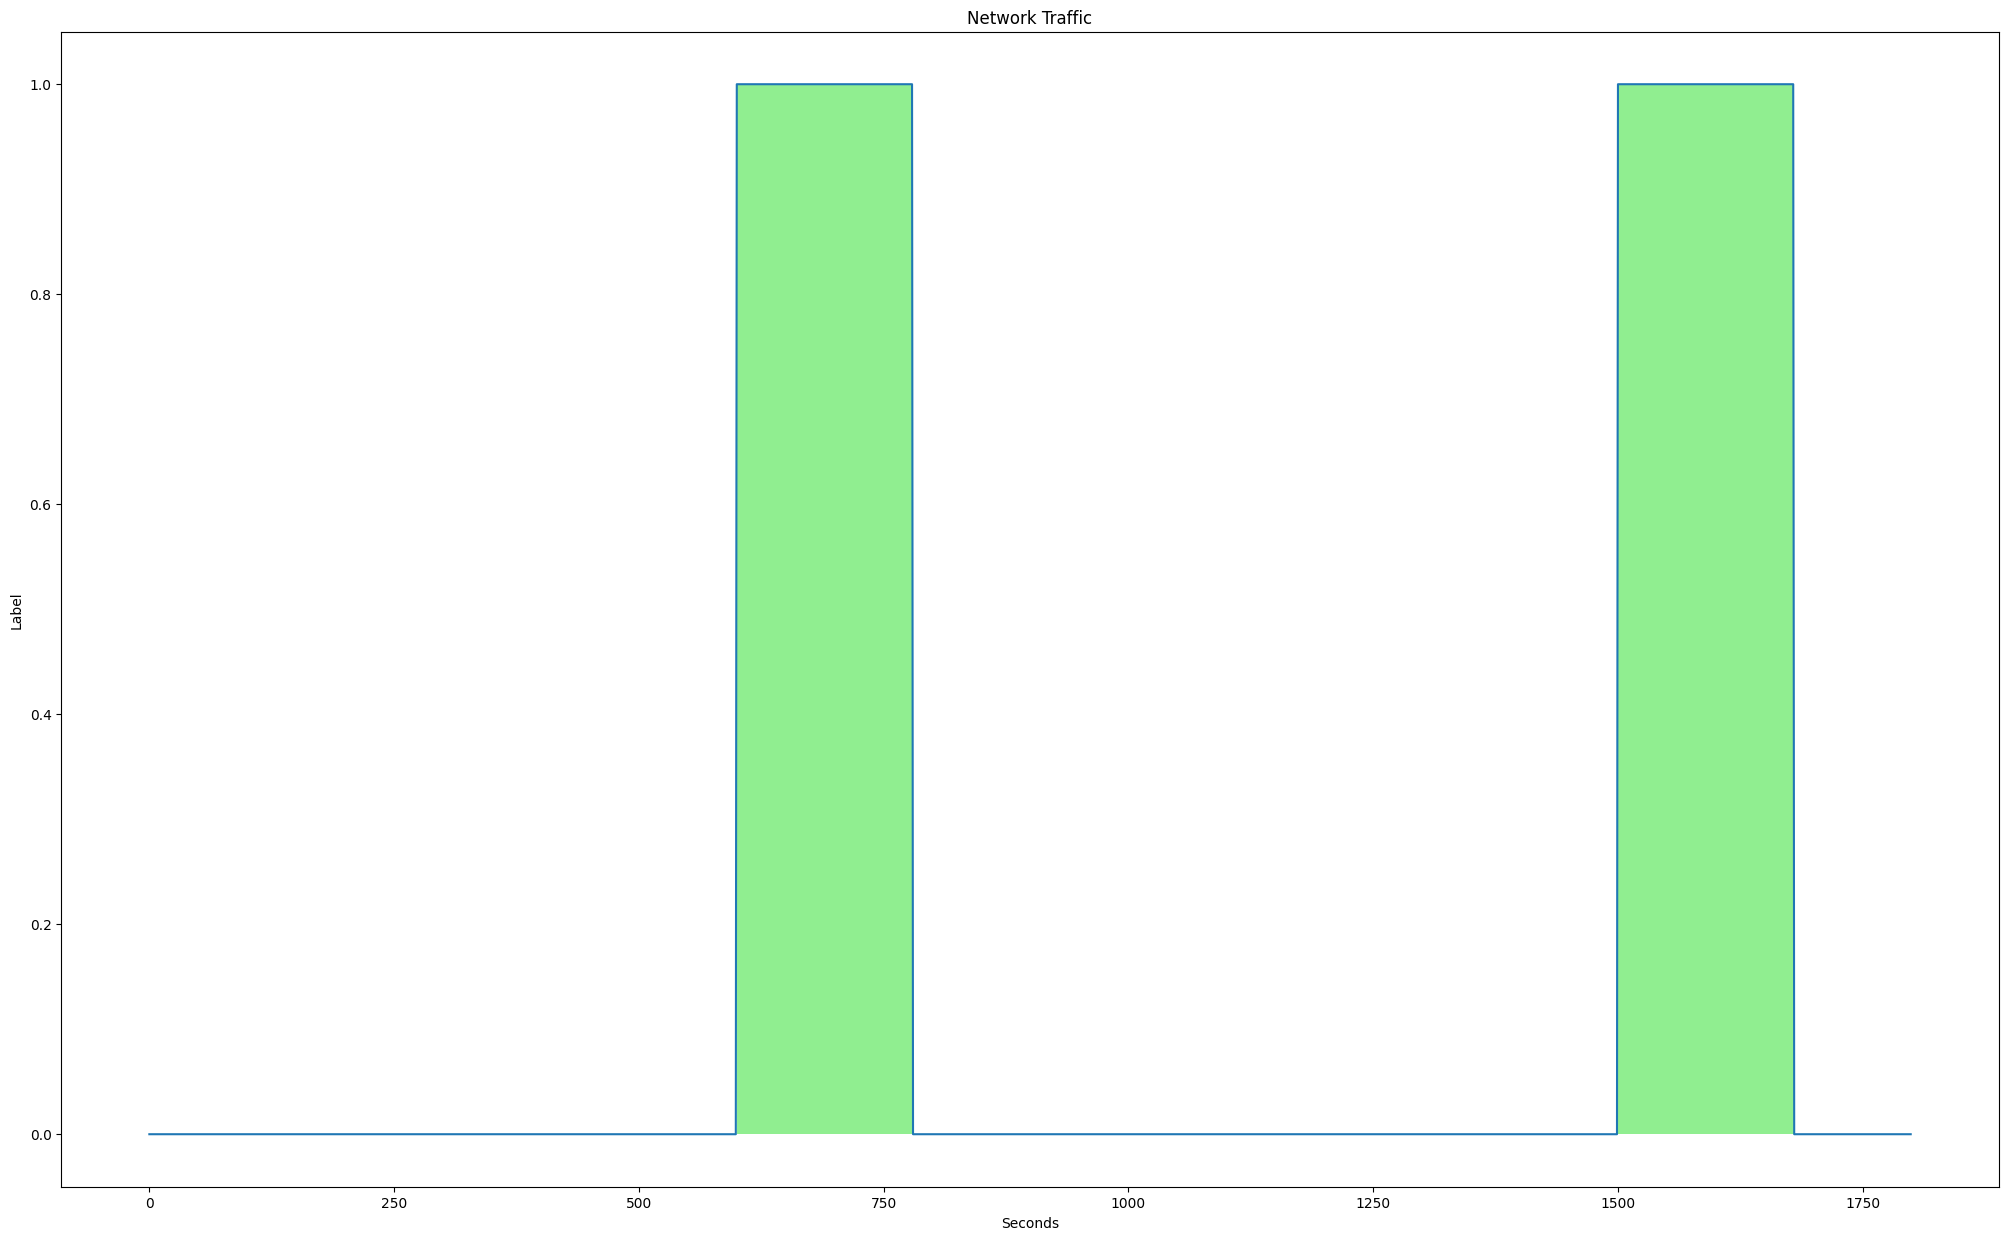

In [65]:
plot_ddos(syn_df, [('syn', 3, 10), ('syn', 3, 25)])

## 1. Sadece SYN Flood olan 30 dakikalık veriseti

### Referans Makalede kullanılan yöntem

Selected Feature : <b>Fwd Packets Length Std</b><br>
Threshold : <b>0.5</b><br>
Accuracy  : <b>0.93</b>

#### 1. Syn Flood

In [151]:
print("WINDOW SIZE : 10")
MatrixProfileManager.global_df = syn_df.copy()
thresholded_mp_syn = ThresholdMatrixProfile(pd.DataFrame(syn_df[" Fwd Packet Length Std"]), window_size=10, threshold=2)
_, _ = thresholded_mp_syn.calculate_cost()
display(thresholded_mp_syn.creport)

WINDOW SIZE : 10


{'precision': 1.0,
 'recall': 0.29444444444444445,
 'f1-score': 0.45493562231759654,
 'support': 360,
 'accuracy': 0.8588888888888889}

In [179]:
MatrixProfileManager.global_df = syn_df.copy()
isolated_mp_syn = IsolationMatrixProfile(pd.DataFrame(syn_df[" Fwd Packet Length Std"]), window_size=10)
cost, f1_score = isolated_mp_syn.calculate_cost()
display(isolated_mp_syn.creport)

{'precision': 1.0,
 'recall': 0.16111111111111112,
 'f1-score': 0.27751196172248804,
 'support': 360,
 'accuracy': 0.8322222222222222}

#### 2. Syn + NTP

In [67]:
ntp_syn_df = pd.concat([dataset_dict["benign"], dataset_dict["syn"], dataset_dict["syn"],
                        dataset_dict["benign"], dataset_dict["benign"].iloc[:120,:],
                        dataset_dict["ntp"].iloc[:3*60, :], dataset_dict["benign"].iloc[:120,:]], axis=0).reset_index(drop=True)

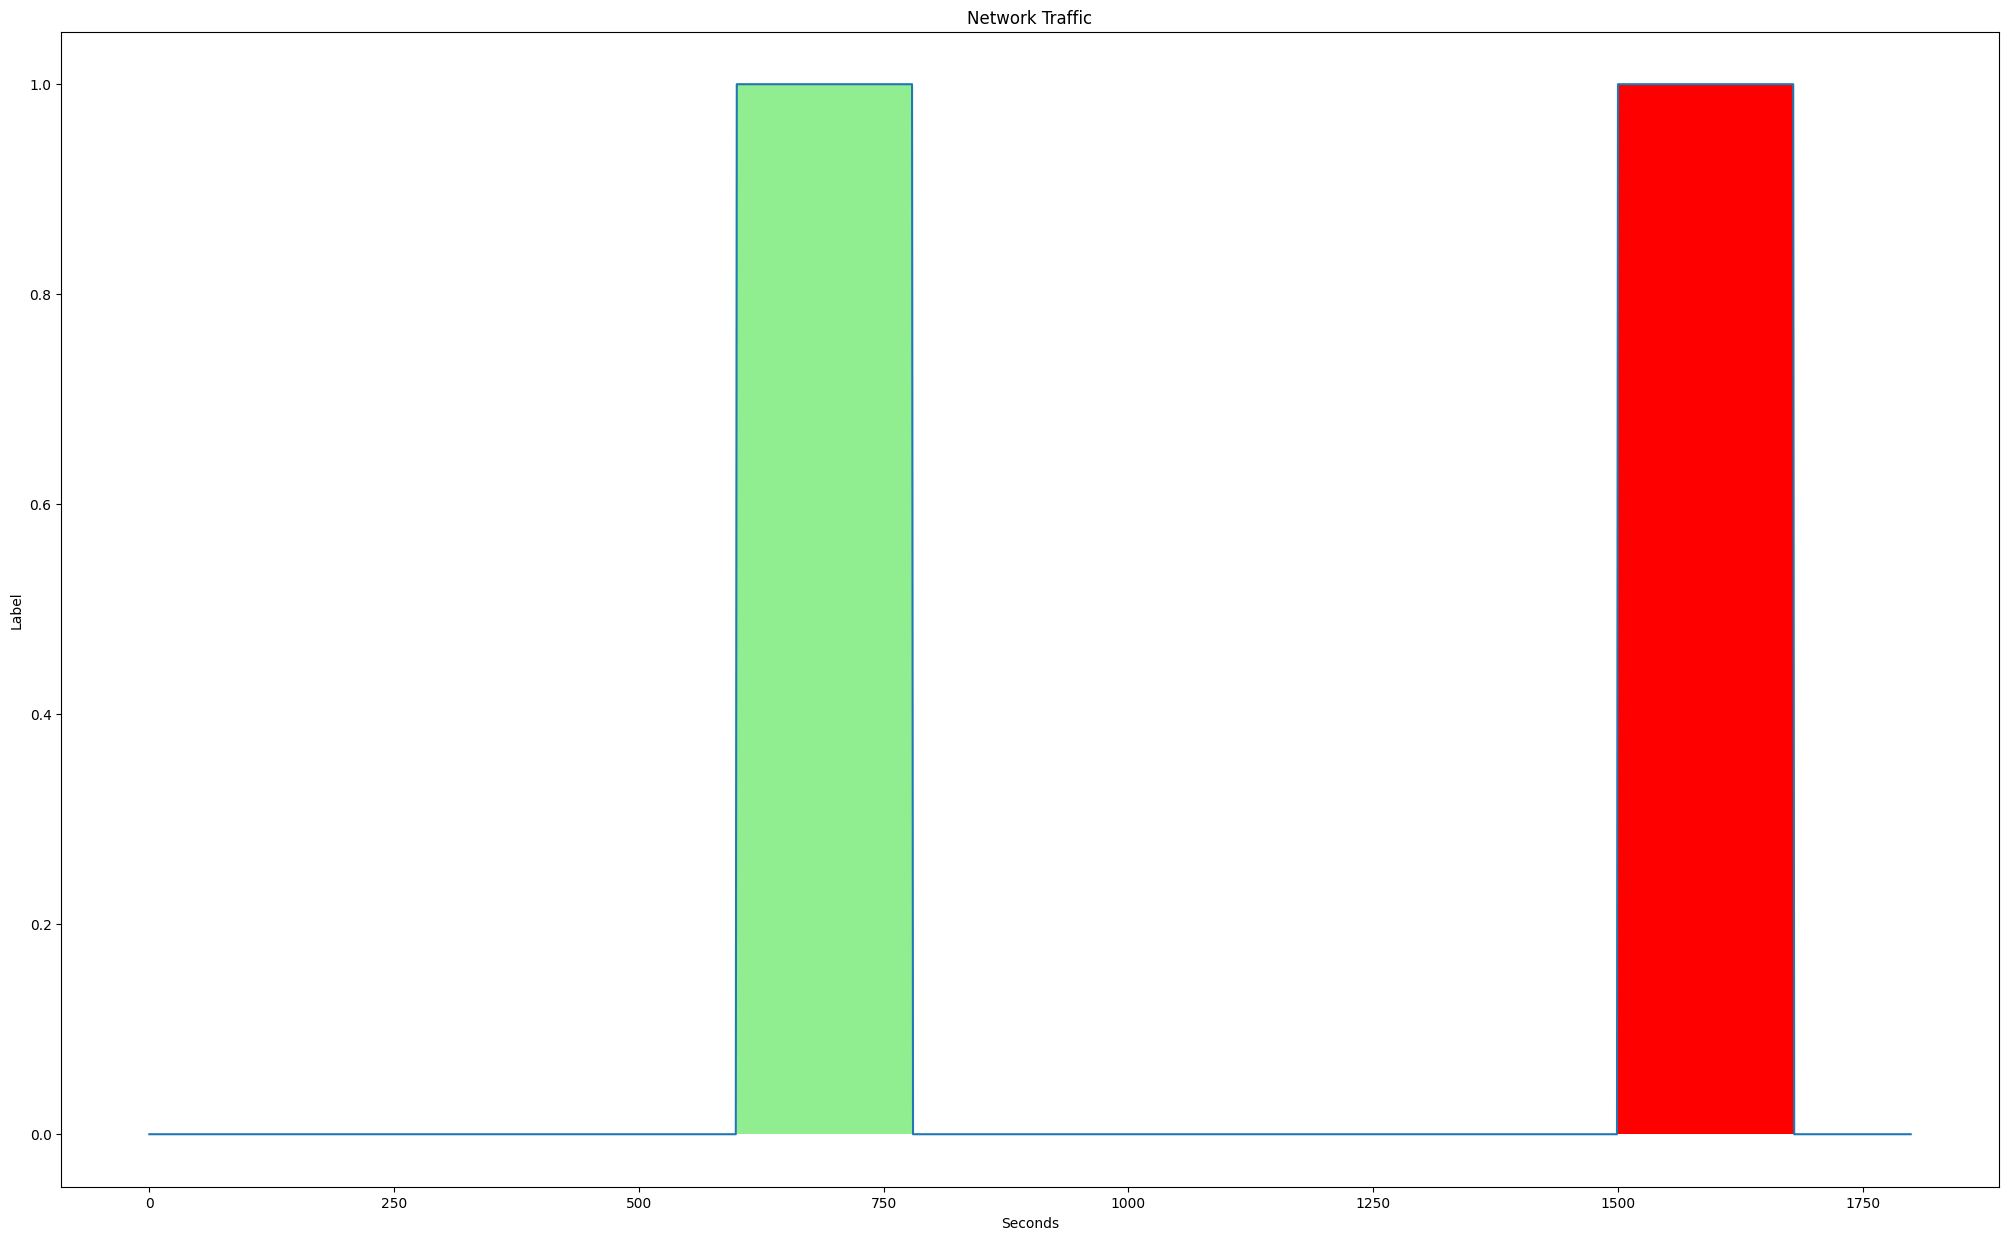

In [68]:
plot_ddos(ntp_syn_df, [('syn', 3, 10), ('ntp', 3, 25)])

Window Size : PRECISION & RECALL TradeOff

In [150]:
print("WINDOW SIZE : 10")
MatrixProfileManager.global_df = ntp_syn_df.copy()
thresholded_mp = ThresholdMatrixProfile(pd.DataFrame(ntp_syn_df[" Fwd Packet Length Std"]), window_size=10, threshold=2)
cost, f1_score = thresholded_mp.calculate_cost()
display(thresholded_mp.creport)

WINDOW SIZE : 10


{'precision': 1.0,
 'recall': 0.5666666666666667,
 'f1-score': 0.7234042553191489,
 'support': 300,
 'accuracy': 0.9252873563218391}

In [149]:
print("WINDOW SIZE : 60")
MatrixProfileManager.global_df = ntp_syn_df.copy()
thresholded_mp = ThresholdMatrixProfile(pd.DataFrame(ntp_syn_df[" Fwd Packet Length Std"]), window_size=60, threshold=2)
cost, f1_score = thresholded_mp.calculate_cost()
display(thresholded_mp.creport)

WINDOW SIZE : 60


{'precision': 0.7194244604316546,
 'recall': 1.0,
 'f1-score': 0.8368200836820083,
 'support': 300,
 'accuracy': 0.9327586206896552}

In [177]:
MatrixProfileManager.global_df = ntp_syn_df.copy()
isolated_mp_ntp = IsolationMatrixProfile(pd.DataFrame(ntp_syn_df[" Fwd Packet Length Std"]), window_size=60)
cost, f1_score = isolated_mp_ntp.calculate_cost()
display(isolated_mp_ntp.creport)

{'precision': 0.7177033492822966,
 'recall': 1.0,
 'f1-score': 0.8356545961002785,
 'support': 300,
 'accuracy': 0.9321839080459771}

#### 3. NTP + UDP

In [156]:
udp_ntp_df = pd.concat([dataset_dict["benign"], dataset_dict["ntp"].iloc[:3*60,:],
                        dataset_dict["benign"], dataset_dict["benign"].iloc[:120,:],
                        dataset_dict["udp"].iloc[:3*60, :], dataset_dict["benign"].iloc[:120,:]], axis=0).reset_index(drop=True)

In [175]:
MatrixProfileManager.global_df = udp_ntp_df.copy()
thresholded_mp_udp = ThresholdMatrixProfile(pd.DataFrame(udp_ntp_df[" Fwd Packet Length Std"]), window_size=60, threshold=2)
cost, f1_score = thresholded_mp_udp.calculate_cost()
display(thresholded_mp_udp.creport)

{'precision': 0.5628517823639775,
 'recall': 1.0,
 'f1-score': 0.7202881152460985,
 'support': 300,
 'accuracy': 0.8660919540229886}

In [176]:
MatrixProfileManager.global_df = udp_ntp_df.copy()
isolated_mp_udp = IsolationMatrixProfile(pd.DataFrame(udp_ntp_df[" Fwd Packet Length Std"]), window_size=60)
cost, f1_score = isolated_mp_udp.calculate_cost()
display(isolated_mp_udp.creport)

{'precision': 0.7177033492822966,
 'recall': 1.0,
 'f1-score': 0.8356545961002785,
 'support': 300,
 'accuracy': 0.9321839080459771}

### 4. Mix Of Attacks 

In [371]:
mixed_df = pd.concat([dataset_dict["benign"], dataset_dict["ntp"].iloc[:60,:],
                        dataset_dict["benign"], dataset_dict["udp"].iloc[:60, :], dataset_dict["benign"].iloc[:300,:],
                     dataset_dict["syn"].iloc[:30,:], dataset_dict["ntp"].iloc[:30,:],
                      dataset_dict["benign"],  dataset_dict["benign"],
                     dataset_dict["udp"].iloc[:30, :],  dataset_dict["benign"]], axis=0).reset_index(drop=True)

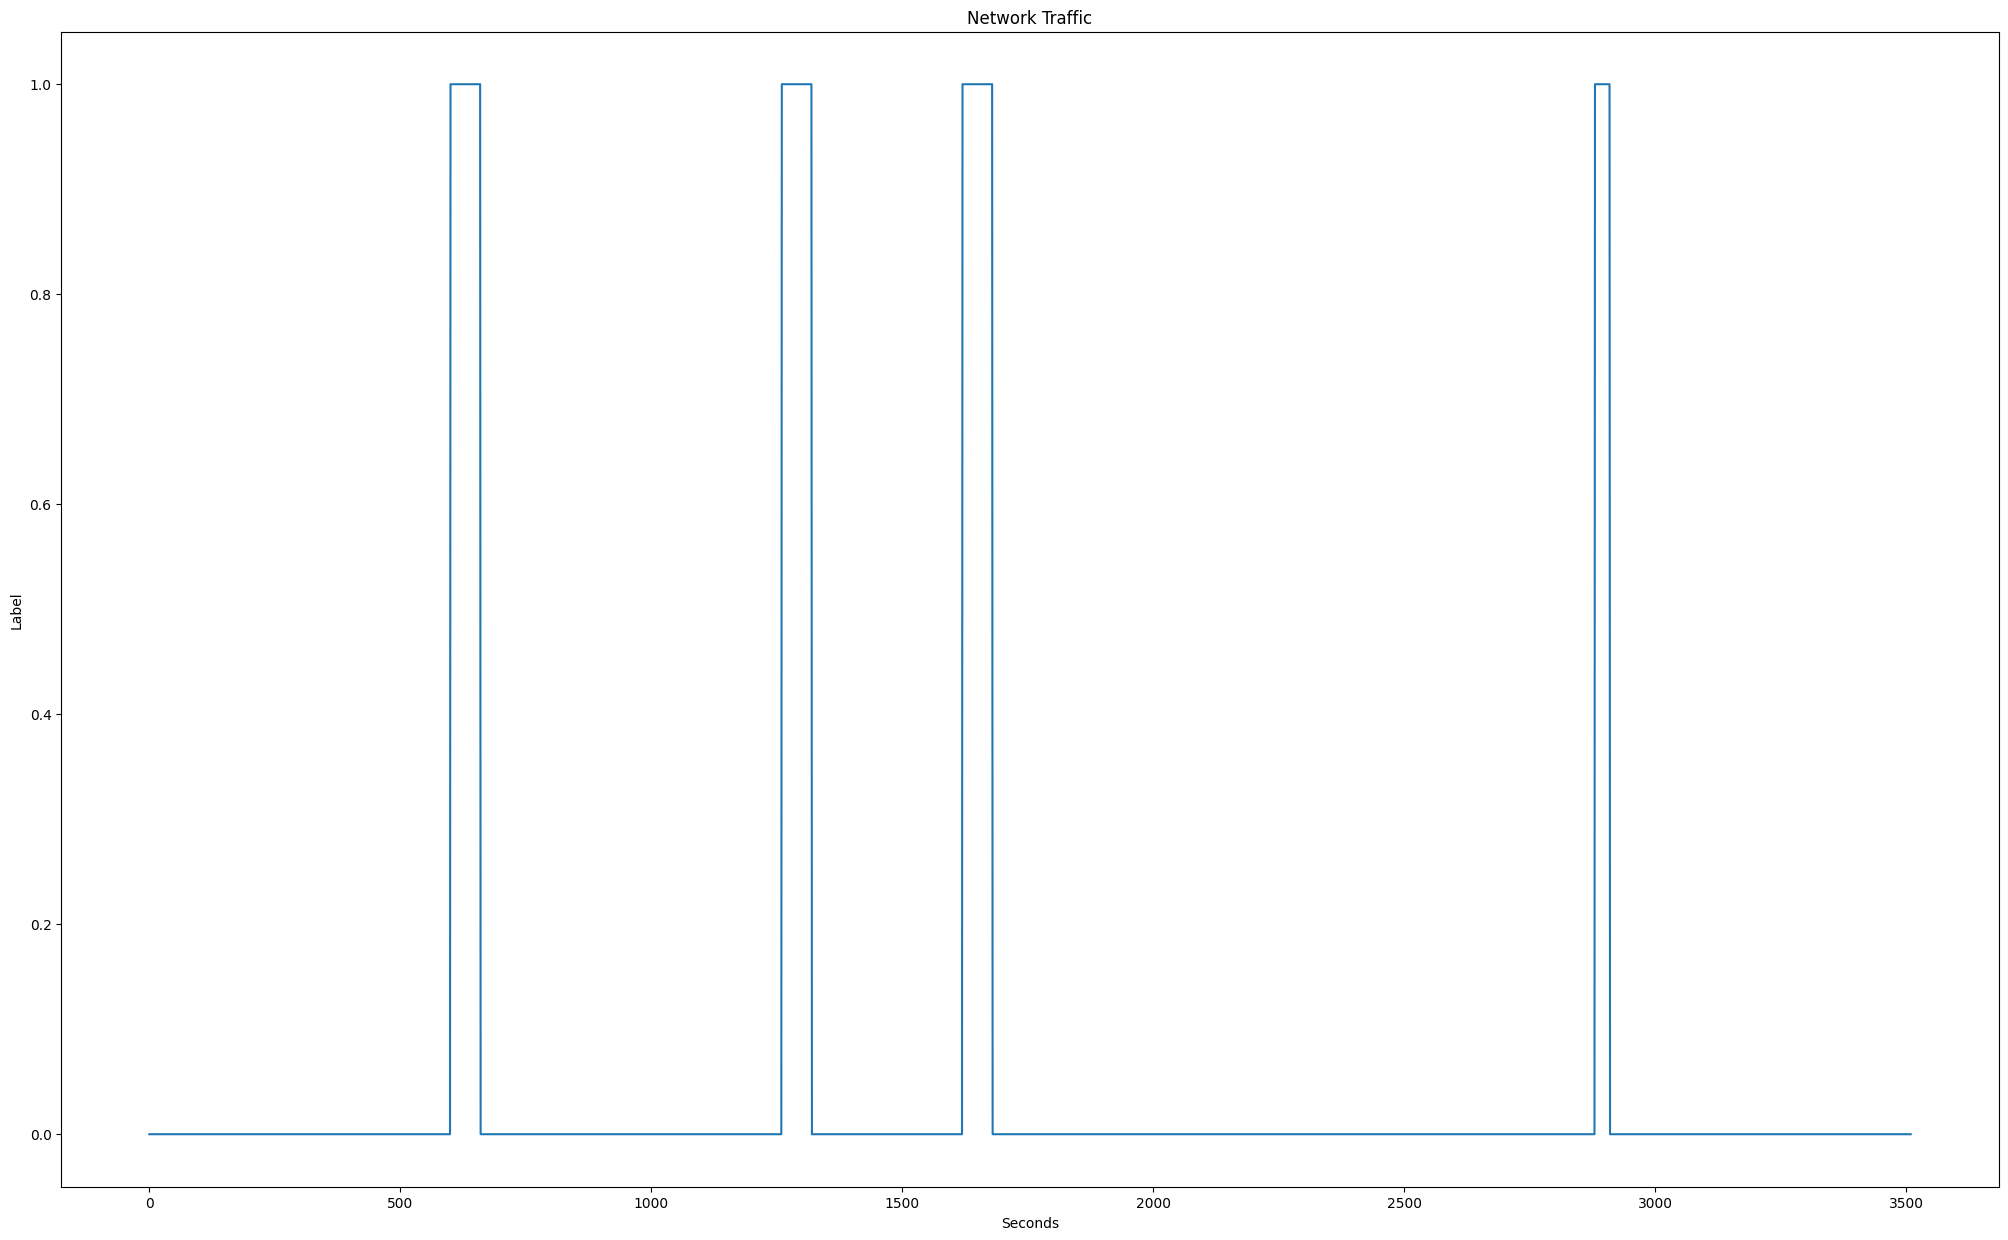

In [372]:
plot_ddos(mixed_df, attack_list=[])

In [373]:
mixed_df = mixed_df.drop([' Bwd Packet Length Min'], axis = 1)
listem = [*list(range(0,28)), len(mixed_df.columns) - 1]
mixed_df = mixed_df.iloc[:,listem]

In [374]:
MatrixProfileManager.global_df = mixed_df.copy()
thresholded_mp = ThresholdMatrixProfile(pd.DataFrame(mixed_df[" Fwd Packet Length Std"]), window_size=10, threshold=2)
cost, f1_score = thresholded_mp.calculate_cost()
display(thresholded_mp.creport)

{'precision': 0.9852941176470589,
 'recall': 0.319047619047619,
 'f1-score': 0.48201438848920863,
 'support': 210,
 'accuracy': 0.958974358974359}

In [375]:
MatrixProfileManager.global_df = mixed_df.copy()
isolated_mp = IsolationMatrixProfile(pd.DataFrame(mixed_df[" Fwd Packet Length Std"]), window_size=10)
cost, f1_score = isolated_mp.calculate_cost()
display(isolated_mp.creport)

{'precision': 0.9052631578947369,
 'recall': 0.819047619047619,
 'f1-score': 0.8600000000000001,
 'support': 210,
 'accuracy': 0.9840455840455841}

In [376]:
MatrixProfileManager.global_df = mixed_df.copy()
#isolated_mp = IsolationMatrixProfile(pd.DataFrame(mixed_df[" Fwd Packet Length Std"]), window_size=60)
isolated_mp = IsolationMatrixProfile(pd.DataFrame(mixed_df.iloc[:,1:10]), window_size=10)
cost, f1_score = isolated_mp.calculate_cost()
display(isolated_mp.creport)

{'precision': 0.8898305084745762,
 'recall': 1.0,
 'f1-score': 0.9417040358744395,
 'support': 210,
 'accuracy': 0.9925925925925926}

In [377]:
f1_score_list = []
for col in mixed_df.columns[1:-1]:
    isolated_mp = IsolationMatrixProfile(pd.DataFrame(mixed_df[col]), window_size=10)
    cost, f1_score = isolated_mp.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]


[(0.9270588235294117, ' Bwd IAT Max'),
 (0.9210526315789475, ' Flow IAT Max'),
 (0.9209302325581394, ' Flow IAT Mean'),
 (0.9090909090909091, ' Fwd IAT Min'),
 (0.903846153846154, ' Total Fwd Packets')]

In [378]:
class MatrixProfileManager:
    if 'global_df' not in dir():
        global_df = None
        
    def __init__(self, df:pd.DataFrame, window_size:int = 60, method = 'mpx'):
        if (type(df) == pd.Series):
            df = pd.DataFrame(df)
            
        if (type(df) != pd.DataFrame):
            raise ValueError("df must be pd.DataFrame")
            
        self.df = df
        self.window_size = window_size
        self.mp_method = method
        self.discord_dict = {}
        self.discords = []
        self.curr_mp_dict = {}
        self.mps = None
        self.pred_df = pd.DataFrame()
        self.method_func_dict = {'mpx'     : self.calculate_mp_seperately_mpx,
                                 'mstump'  : self.calculate_mp_multivariate_stumpy}
        
    def calculate_mp_multivariate_stumpy(self):
        from stumpy import mstump
        curr_mps, curr_indices = mstump(self.df, self.window_size)
        self.mps = curr_mps
        
    def calculate_mp_seperately_mpx(self):
        import matrixprofile as mp
        mp_list = []
        
        for ft in self.df.columns:
            inputSignal = self.df[ft].to_list()
            matrix_profile = mp.compute(inputSignal, windows=self.window_size, threshold=0.95, n_jobs=4)
            mp_list.append(matrix_profile['mp'])

        self.mps = np.array(mp_list)
        
        
        
    def calculate_discords(self):
        raise NotImplementedError("Base Class Env")
        
    def majority_vote_discords(self):
        raise NotImplementedError("Base Class Env")
        
    def obtain_y_vals(self):
        if (MatrixProfileManager.global_df is None):
            raise ValueError("global df is none")
            
        df_idxs = list(range(0, len(MatrixProfileManager.global_df)))
        benign_preds = [idx for idx in df_idxs if idx not in self.discords]
  
        self.pred_df['y_true'] = MatrixProfileManager.global_df["Label"].copy()
        self.pred_df["y_pred"] = MatrixProfileManager.global_df["Label"].copy()
        
        self.pred_df.iloc[df_idxs, 1] = 0
        self.pred_df.iloc[self.discords, 1] = 1
        
    def calculate_classification_report(self):
        from sklearn.metrics import classification_report
        if 'y_true' not in self.pred_df.columns:
            raise ValueError('true vals not included in df')

        if 'y_pred' not in self.pred_df.columns:
            raise ValueError('pred vals not included in df')

        out_dict = classification_report(self.pred_df["y_true"].to_list(),
                                             self.pred_df["y_pred"].to_list(), output_dict=True)
        
        self.creport = out_dict["1"]
        self.creport["accuracy"] = out_dict["accuracy"]
        
    def get_f1_score(self):
        if self.creport is None:
            raise ValueError('Classification Report is not ready!')
            
        return self.creport['f1-score']

    def get_mp_score(self):
        #maximize this
        import numpy as np
        return 0
        #return sum([sum(np.log10(1+mp_score)) for mp_score in self.curr_mp_dict.values()]) / len(self.curr_mp_dict.keys())
        
    def calculate_cost(self):
        self.method_func_dict[self.mp_method.lower()]()
        
        self.calculate_discords()
        self.majority_vote_discords()
        self.obtain_y_vals()
        self.calculate_classification_report()

        f1_score = self.get_f1_score()
        mp_score = self.get_mp_score()
        return mp_score, f1_score
        

In [379]:
class ThresholdMatrixProfile(MatrixProfileManager):
    def __init__(self, df:pd.DataFrame, window_size:int = 60, method = 'mpx', threshold:float=2.0):
        super().__init__(df, window_size, method)
        self.threshold = threshold
        
    def calculate_discords(self):
        curr_mps_dict = {f_idx: np.where(self.mps[idx] > self.threshold)[0].tolist()
                         for idx, f_idx in enumerate(self.df.columns)}
        
        
        for idx, indices in curr_mps_dict.items():
            indice_list = []
            for indice in indices:
                #get mp point window
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            self.discord_dict[idx] = list(set(indice_list))
                        
    def majority_vote_discords(self):
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list)

        self.discords = list(set(overall_list))
        

        



In [380]:
class IsolationMatrixProfile(MatrixProfileManager):
    def __init__(self, df:pd.DataFrame, window_size:int = 60, method = 'mpx'):
        super().__init__(df, window_size, method)
        
    def calculate_discords(self):
        import numpy as np
        from sklearn.ensemble import IsolationForest
        curr_mps_dict = {f_idx: np.log10((1 + self.mps[idx])).tolist()
                            for idx, f_idx in enumerate(self.df.columns)}
        
        self.mps_df= pd.DataFrame(curr_mps_dict)
        model=IsolationForest()
        model.fit(self.mps_df.iloc[:,:])
        
        self.mps_df['scores']=model.decision_function(self.mps_df.iloc[:,:])
        self.mps_df['anomaly']=model.predict(self.mps_df.iloc[:, :-1])
        
    def majority_vote_discords(self):
        self.discords = self.mps_df[self.mps_df["anomaly"] == -1].index.to_list()


In [381]:
class PredefinedMatrixProfile(MatrixProfileManager):
    def __init__(self, df:pd.DataFrame, window_size:int = 60, method = 'mpx', discord_number:int=0):
        if (discord_number < 1):
            raise ValueError("Discord Number Can Not be Lower than 1")
        super().__init__(df, window_size, method)
        self.discord_number = discord_number
        
    def calculate_discords(self):
        from collections import Counter
        curr_mps_dict = {f_idx: np.argsort(self.mps[idx])[::-1][:1000] for idx, f_idx in enumerate(self.df.columns)}
        self.curr_mp_dict = {f_idx: np.sort(self.mps[idx])[::-1][:self.discord_number]
                             for idx, f_idx in enumerate(self.df.columns)}

        for idx, indices in curr_mps_dict.items():
            indice_list = []
            for indice in indices:
                indice_list.extend(list(range(indice, indice + self.window_size - 1)))

            sorted_discords = sorted(Counter(indice_list).items(), key=lambda t:t[1], reverse=True)
            sorted_discord_indexes = [elem[0] for elem in sorted_discords[:self.discord_number]]

            self.discord_dict[idx] = sorted_discord_indexes
        
        
    def majority_vote_discords(self):
        from collections import Counter
        overall_list = []
        for ft, ids_list in self.discord_dict.items():
            overall_list.extend(ids_list)

        sorted_overall = (sorted(Counter(overall_list).items(), key=lambda t:t[1], reverse=True))
        self.discords = [elem[0] for elem in sorted_overall[:self.discord_number]]
        

In [382]:
import pandas as pd
import random
from enum import Enum


class MPMethod(Enum):
    ThresholdBase = 0
    IsolationForest = 1
    PredefinedDiscords = 2

class FitnessType(Enum):
    F1_Score = 0
    LOG_MP_SUM = 1

class Verbosity(Enum):
    NoLog  = 0
    HalfLog = 1
    FullLog = 2
    
    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplementedError("!!!")


class GeneticAlgo:
    verbosity_level = Verbosity.NoLog
    mp_map = {  MPMethod.ThresholdBase : ThresholdMatrixProfile,
                MPMethod.IsolationForest : IsolationMatrixProfile,
                MPMethod.PredefinedDiscords : PredefinedMatrixProfile}

    def __init__(self, df:pd.DataFrame,
                 max_features:int,
                 population_bag_size:int = 3,
                 fitness : FitnessType = FitnessType.F1_Score,
                 mp_method : MPMethod = MPMethod.ThresholdBase, **kwargs):
        
        #mp_kwargs : TH{'threshold' : 2.0} , PR{'discord_number' : 500} olabilir.
        
        print('Genetic Algorithm Process is ready to start')
        self.df = df.copy()
        self.feature_number = max_features
        self.pop_bag_size = population_bag_size
        self.fitness_type = fitness
        self.mp_method = mp_method
        self.mp_kwargs = kwargs
        
        self.y = df[["Label"]]
        self.X = df.drop(["Label"], axis = 1)
        self.feature_map = {i : feat_name for i, feat_name in enumerate(self.X.columns)}
        self.X.columns = list(range(0, len(self.X.columns)))

        self.creport = None
        self.eval_result = None


    def initialize_population(self):
        self.population_bag = []
        for _ in range(self.pop_bag_size):
            #0 veya 1 atiyoruz feature pick or not pick, 1 olanlari appendliyoruz.
            genes = [random.randrange(0,2) for _ in range(self.feature_number)]
            gene_indexes = [idx for idx, f in enumerate(genes) if f == 1]
            if (len(gene_indexes) == 0):
                gene_indexes.append(random.randint(1,self.feature_number))

            self.population_bag.append(self.X.iloc[:, gene_indexes])

        return self.population_bag

    def create_population(self, pop_bag) -> pd.DataFrame:
        self.population_bag.clear()
        for elem in pop_bag:
            self.population_bag.append(self.X.iloc[:, elem])
            
        return self.population_bag


    def fitness_function(self, individual:pd.DataFrame):
            mp_manager = GeneticAlgo.mp_map[self.mp_method](df=individual, **(self.mp_kwargs))
            cost, f1_score = mp_manager.calculate_cost()
                
            if (GeneticAlgo.verbosity_level > Verbosity.NoLog):
                print(f'processing solution: {individual.columns.to_list()}')
                print(f"f1-score is: {mp_manager.get_f1_score()}")
                            
            del mp_manager
            return cost, f1_score
        
    def eval_fit_population(self, pop_bag):
            #This evaluation is based on minimizing the cost!
            result = {}
            fit_vals_lst = []
            f1_score_lst = []
            solutions = []
            for individual in pop_bag:
                if (type(individual) != pd.DataFrame):
                    assert(True)

                cost, f1_sc = self.fitness_function(individual.copy())
                fit_vals_lst.append(cost)
                f1_score_lst.append(f1_sc)
                solutions.append(individual.columns.to_list())

            result["fit_vals"] = fit_vals_lst
            result["f1-scores"] = f1_score_lst 
            if self.fitness_type == FitnessType.LOG_MP_SUM:
                min_wgh = [abs(np.min(list(result['fit_vals'])) - i) for i in list(result['fit_vals'])]
            elif (self.fitness_type == FitnessType.F1_Score):
                min_wgh = [abs(np.min(list(result['f1-scores'])) - i) for i in list(result['f1-scores'])]

            from scipy.special import logsumexp
            #TODO: find a way instead of logsumexp
            result["fit_wgh"]  = [i/logsumexp(min_wgh) for i in min_wgh]
            result["solution"] = np.array(solutions, dtype=list).tolist()

            self.eval_result = result.copy()
            return result
        
    def find_best(self, eval_result:dict)->dict:
        # Best individual so far
        best_fit = np.max(eval_result["fit_vals"])
        best_fit_index = eval_result["fit_vals"].index(best_fit)
        best_solution  = eval_result["solution"][best_fit_index]
        f1_sc = eval_result["f1-scores"][best_fit_index]
        if (GeneticAlgo.verbosity_level > Verbosity.NoLog):
            print(f'best fit: {best_fit}\nsolution: {best_solution}\nf1Score: {f1_sc}')
        return {'best_fit': best_fit, 'index' : best_fit_index,
                 'solution': best_solution, 'f1-score' : f1_sc}

    def pick_one(self, pop_bag):
        
        if self.eval_result is None:
            eval_result = self.eval_fit_population(pop_bag)
        else:
            eval_result = self.eval_result

        notPicked=True
        cnt = 0
        pickedSol = list()
        while (notPicked == True):
            rnIndex = random.randint(0, len(pop_bag)-1)
            rnPick  = eval_result["fit_wgh"][rnIndex]
            r = random.random()
            if  r <= rnPick:
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            if (cnt > 250):
                pickedSol = eval_result["solution"][rnIndex]
                notPicked = False
            cnt += 1

        return pickedSol

    def crossover(self, solA, solB):
        
        n     = len(solA)
        child: list = []

        num_els = random.randint(0, self.feature_number)
        str_pnt = random.randint(0, max(0,n-3))
        end_pnt = n if int(str_pnt+num_els) > n else int(str_pnt+num_els)

        blockA = list(solA[str_pnt:end_pnt])
        child = blockA.copy()

        for elem in solB:
            if len(child) >= num_els:
                break
            if elem not in blockA:
                child.append(elem)  

        if (len(child) < 1):
            return solA

        return child

    def mutation(self,sol):
        if (len(sol) > 2):
            rd_idx = random.randint(0, len(sol) - 1)
            del sol[rd_idx]
        return sol

In [385]:
GA = GeneticAlgo(mixed_df.iloc[:,1:].copy(), max_features=20, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.ThresholdBase,  window_size=10)


pop_bag = GA.initialize_population()
generation_number = 20

import random
for generation in range(generation_number):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.87:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {best_f1_score}")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 1 is started!
Generation 2 is started!
Generation 3 is started!
Generation 4 is started!
Generation 5 is started!
Generation 6 is started!
Generation 7 is started!
Generation 8 is started!
Generation 9 is started!
Generation 10 is started!
Generation 11 is started!
Generation 12 is started!
Generation 13 is started!
Generation 14 is started!
Generation 15 is started!
Generation 16 is started!
Generation 17 is started!
Generation 18 is started!
Generation 19 is started!


**** Generations Over ****

Best Fitness: 0
Best Solution: [7, 9, 14, 6, 11, 16, 17]
F1-Score: 0.8483290488431876


In [387]:
mixed_df.columns.to_list()

['Date_Second',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 'Label']

In [384]:
f1_score_list = []
MatrixProfileManager.global_df = mixed_df.copy()
for col in mixed_df.columns[1:-1]:
    isolated_mp = ThresholdMatrixProfile(pd.DataFrame(mixed_df[col]), window_size=10, threshold=0.5)
    cost, f1_score = isolated_mp.calculate_cost()
    f1_score_list.append((f1_score, col))
    
sorted(f1_score_list, key=lambda x:x[0], reverse=True)[:5]


C:\Users\batuh\anaconda3\envs\tez_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\batuh\anaconda3\envs\tez_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\batuh\anaconda3\envs\tez_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[(0.7840375586854459, ' Fwd Packet Length Min'),
 (0.7458563535911602, ' Flow IAT Mean'),
 (0.7457627118644068, ' Fwd Packet Length Std'),
 (0.7403314917127072, ' Flow IAT Std'),
 (0.736842105263158, ' Fwd IAT Std')]

In [334]:
f1

0.5

In [388]:
GA = GeneticAlgo(mixed_df.iloc[:,1:].copy(), max_features=20, population_bag_size=10,
                 fitness=FitnessType.F1_Score,
                 mp_method=MPMethod.IsolationForest,  window_size=10)


pop_bag = GA.initialize_population()
generation_number = 20

import random
for generation in range(generation_number):
        print(f"Generation {generation} is started!")
        
        res = GA.eval_fit_population(pop_bag)
        best_fit, _, best_solution, best_f1_score = GA.find_best(res).values()
        
        if (generation == 0):
            best_fit_global      = best_fit
            best_solution_global = best_solution
            best_f1_global       = best_f1_score
        else:
            if (best_f1_score >= best_f1_global):
                best_fit_global      = best_fit
                best_f1_global       = best_f1_score
                best_solution_global = best_solution

        new_pop_bag = []
        for i in range(len(GA.population_bag)):
                # Pick 2 parents from the bag
            pA = GA.pick_one(pop_bag)
            pB = GA.pick_one(pop_bag)
            new_element = pA
            # Crossover the parents
            if random.random() <= 0.87:
                new_element = GA.crossover(pA, pB)
            #Mutate the child
            if random.random() <= 0.5:
                new_element = GA.mutation(new_element) 
            
            # Append the child to the bag
            new_pop_bag.append(new_element)
            # Set the new bag as the population bag
        pop_bag = GA.create_population(new_pop_bag)
        
print("\n\n**** Generations Over ****\n")
print(f"Best Fitness: {best_fit_global}")
print(f"Best Solution: {best_solution_global}")
print(f"F1-Score: {best_f1_score}")

Genetic Algorithm Process is ready to start
Generation 0 is started!
Generation 1 is started!
Generation 2 is started!
Generation 3 is started!
Generation 4 is started!
Generation 5 is started!
Generation 6 is started!
Generation 7 is started!
Generation 8 is started!
Generation 9 is started!
Generation 10 is started!
Generation 11 is started!
Generation 12 is started!
Generation 13 is started!
Generation 14 is started!
Generation 15 is started!
Generation 16 is started!
Generation 17 is started!
Generation 18 is started!
Generation 19 is started!


**** Generations Over ****

Best Fitness: 0
Best Solution: [19, 4, 11, 7, 0, 17, 6, 13, 8, 14, 16, 5]
F1-Score: 0.958904109589041
